# Red or blue galaxies?

### By: [Natalí S. M. de Santi](https://natalidesanti.github.io)

In this notebook we will see how to predict if a galaxy is **red** or **blue** using some galaxy properties and a ML method called **Random Forest** (RF)

## Summary

1) Running options
2) Motivation
3) Libraries required
4) Handling data
5) Random Forest

## 1) Running options

* **On the fly:** you can easily open it in `google colab`: [![Open this notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github.com/natalidesanti/ML4cosmology/blob/main/notebooks/redXblue.ipynb)
* **On your won computer:** you can download the notebook and work on this. Just make sure you have all the libraries installed

## 2) Motivation

One of the main galaxies properties is **color**, due to the fact that we primary measure galaxy **magnitudes** (a measure of luminosity),
what composes the well-known **galaxy color-magnitude diagram**:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Galaxy_color-magnitude_diagram-en.svg/300px-Galaxy_color-magnitude_diagram-en.svg.png)
###### [Image source: [Wikipedia](https://en.wikipedia.org/wiki/Galaxy_color–magnitude_diagram)]

Galaxy color is a way to start describing a bunch of other galaxy properties: e.g. _red galaxies_ are tipically _elliptical_, while _blue_ galaxies are tipically _spirals_.

If you are interested on knowing more about galaxy properties, take a look at these amazing papers:

* Donnary et al. [arXiv:1812.07584](https://arxiv.org/abs/1812.07584)
* Bell et al. [arxiv:0303394](https://arxiv.org/abs/astro-ph/0303394)
* Conselice et al. [arXiv:0610016](https://arxiv.org/abs/astro-ph/0610016)

## Libraries required

Many of these libraries can be installed using the following command line:

`pip install name_of_the_library`


Fell free to reach me out if you do not get enough resources online, regarding their installation.

In [3]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

## 4) Handling data

First things first, what is the dataset we are going to use?

It is a [IllustrisTNG](https://www.tng-project.org) box from a single snapshot (z = 0) from the [CAMELS]((https://camels.readthedocs.io/en/latest/)) simulations.
A complete description of the simulations and data, as well how to download more data, is given in the CAMELS [webpage](https://camels.readthedocs.io/en/latest/subfind.html) documentation page.

### 4.1) Getting and analysing the data

We can download the data using:

In [5]:
!wget -q -nc -O data/fof_subhalo_tab_033.hdf5 https://www.dropbox.com/scl/fi/c7wrsplqjr5b0xwgy1cri/fof_subhalo_tab_033.hdf5?rlkey=1hve3qo7nrdh5qolesfclhlf5&dl=0

zsh:1: no matches found: https://www.dropbox.com/scl/fi/c7wrsplqjr5b0xwgy1cri/fof_subhalo_tab_033.hdf5?rlkey=1hve3qo7nrdh5qolesfclhlf5


**IllustrisTNG** data is a `.hdf5` file. 
We can read the content using the library `h5py`. 
We use the `with` method to ensure that the file is properly opened and closed each time we access it, and specify the `r` to make it clear we are *reading* from the file, not writing. 
We can see what the top level groups and datasets are using the `keys` method:

In [6]:
with h5py.File('../data/fof_subhalo_tab_033.hdf5', 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>


The cosmological information used to run this simulation can be obtained using:

In [7]:
with h5py.File('../data/fof_subhalo_tab_033.hdf5', 'r') as f:
    BoxSize      = f['Header'].attrs[u'BoxSize']/1e3    #size of the snapshot in comoving Mpc/h
    redshift     = f['Header'].attrs[u'Redshift']       #reshift of the snapshot
    scale_factor = f['Header'].attrs[u'Time']           #scale factor
    h            = f['Header'].attrs[u'HubbleParam']    #value of the hubble parameter in 100 km/s/(Mpc/h)
    Omega_m      = f['Header'].attrs[u'Omega0']         #Omega_matter
    Omega_L      = f['Header'].attrs[u'OmegaLambda']    #Omega_baryon

In [8]:
print('Box size:                 %.2f Mpc/h'%BoxSize)
print('snapshot redshift:        %.2f'%redshift)
print('Omega_m:                  %.3f'%Omega_m)
print('Omega_L:                  %.3f'%Omega_L)

Box size:                 25.00 Mpc/h
snapshot redshift:        0.00
Omega_m:                  0.300
Omega_L:                  0.700


Apart from the specifications, the catalogs contain two main groups:

* **Group:** contains the properties of the halos.

* **Subhalos:** contains the properties of the subhalos. Galaxies, are considered as subhalos with stellar mass larger than 0.

In this tutorial we are going to work only with the galaxies. So, le't get some of their properties.

In [9]:
with h5py.File('../data/fof_subhalo_tab_033.hdf5', 'r') as f:
    SM    = f['/Subhalo/SubhaloMassType'][:, 4]*1e10 #Msun/h
    mags = f['Subhalo/SubhaloStellarPhotometrics'][:]
    SFR = f['Subhalo/SubhaloSFR'][:]*1e10 #(Msun/year)/ (10^10 Msun/h)
    R_g  =  f['Subhalo/SubhaloHalfmassRadType'][:, 4] #kpc/h

Let's select only galaxies with a certain **stellar mass** and convert zero star forming galaxies:

In [28]:
threshold = 1.e8

In [29]:
indexes = np.where(SM > threshold)[0]
SM      = SM[indexes]
mags    = mags[indexes]
SFR     = SFR[indexes]
R_g     = R_g[indexes]
indexes.shape

(860,)

In [30]:
SFR[np.where(SFR == 0)[0]] = 10**(8)

IllustrisTNG comes with 8 magnitude bands: U, B, V, K, g, r, i, z.
Here we will work with the color g - r:

In [13]:
color = mags[:, 4] - mags[:, 5]

According to Donnary (2018) we can split the color diagram according to a threshold of 0.6, separating blue and red galaxies:

Text(0.5, 1.0, 'Galaxy color')

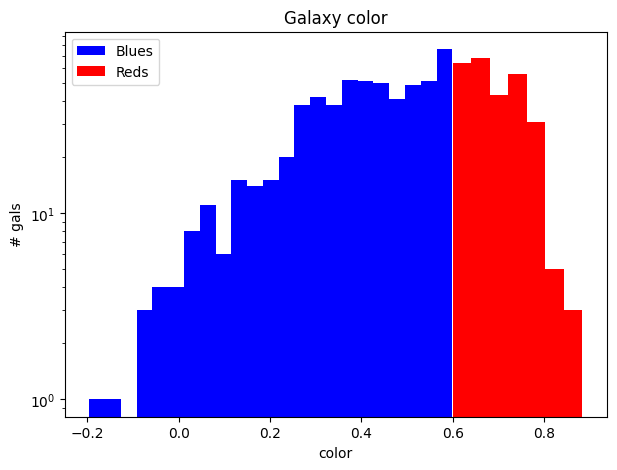

In [27]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.hist(color[np.where(color < 0.6)[0]], bins = 23, color = 'blue', label = 'Blues')
plt.hist(color[np.where(color > 0.6)[0]], bins = 7, color = 'red', label = 'Reds')
plt.yscale('log')
plt.ylabel('# gals')
plt.xlabel('color')
plt.legend()
plt.title('Galaxy color')

In [11]:
color[np.where(color < 0.6)[0]] = int(0)
color[np.where(color > 0.6)[0]] = int(1)

In [12]:
#Galaxy catalog
data = np.array( [ np.log10(SM), color, np.log10(SFR), R_g ] ).T
columns = [ 'SM', 'color', 'SFR', 'R' ] 
gals = pd.DataFrame(data = data, columns = columns)
gals.head(3)

,SM,color,SFR,R
0,11.630214,1.0,8.000000,30.098984
1,10.379946,0.0,10.230370,3.347014
2,10.190658,0.0,9.343358,4.301775


In [13]:
gals.describe()

,SM,color,SFR,R
count,860.000000,860.000000,860.000000,860.000000
mean,9.006678,0.313953,8.747816,4.378883
std,0.766523,0.464368,0.752413,2.179333
min,8.000628,0.000000,7.499816,0.358295
25%,8.341695,0.000000,8.000000,3.064089
50%,8.849222,0.000000,8.639319,3.973066
75%,9.545236,1.000000,9.395308,5.232606
max,11.630214,1.000000,10.878436,30.098984


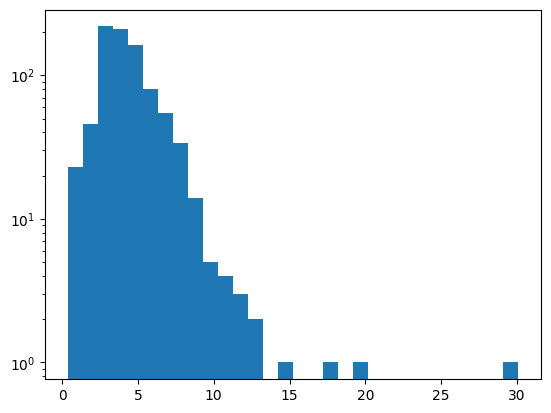

In [14]:
plt.figure(dpi = 100)
plt.hist(gals['R'], bins = 30)
plt.yscale('log')

In [15]:
gals = gals.sample(frac = 1)

In [16]:
X = np.array([gals['SM'], gals['SFR'], gals['R']]).T
y = np.array(gals['color'])
X.shape, y.shape

((860, 3), (860,))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [18]:
model = RandomForestClassifier(random_state = 42, class_weight = 'balanced')

In [19]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [20]:
FI = model.feature_importances_

Text(0.5, 0, 'feature importance')

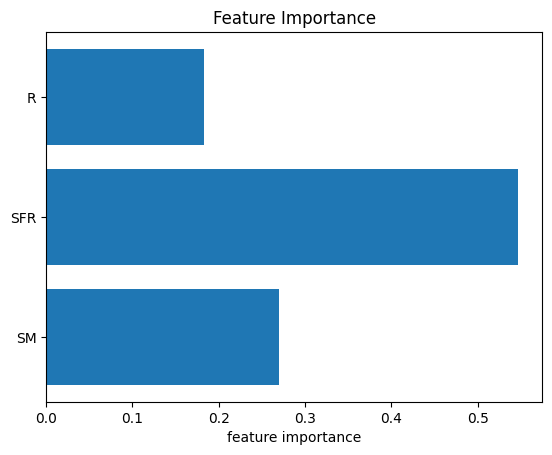

In [21]:
plt.figure(dpi = 100)
plt.title('Feature Importance')
plt.barh(['SM', 'SFR', 'R'], FI)
plt.xlabel('feature importance')

In [22]:
pred = model.predict(X_test)

In [23]:
#Evaluating the model
accuracy = accuracy_score(pred, y_test)
precision = precision_score(pred, y_test)
recall = recall_score(pred, y_test)
f1 = f1_score(pred, y_test)
roc_auc = roc_auc_score(pred, y_test)
cm = confusion_matrix(pred, y_test)

In [24]:
# Print results
print(f"TEST Accuracy: {accuracy:.4f}")
print(f"TEST Precision: {precision:.4f}")
print(f"TEST Recall: {recall:.4f}")
print(f"TEST F1-Score: {f1:.4f}")
print(f"TEST ROC AUC Score: {roc_auc:.4f}")

TEST Accuracy: 0.8663
TEST Precision: 0.7222
TEST Recall: 0.8298
TEST F1-Score: 0.7723
TEST ROC AUC Score: 0.8549


Text(0.5, 23.52222222222222, 'Predicted')

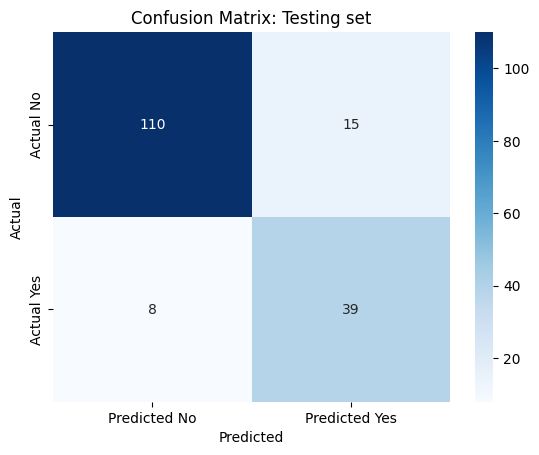

In [25]:
# VTest set
plt.figure(dpi = 100)
plt.title('Confusion Matrix: Testing set')
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', 
            xticklabels = ['Predicted No', 'Predicted Yes'], yticklabels = ['Actual No', 'Actual Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')